##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Universal Sentence Encoder


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Funiversal-sentence-encoder%2F4%20OR%20google%2Funiversal-sentence-encoder-large%2F5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [2]:
%%capture
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [3]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [4]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

#message_embeddings is a list of embeddings
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print(message_embedding[i])
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))


0.008344488218426704
Message: Elephant
Embedding size: 512
Embedding: [0.008344488218426704, 0.00048085825983434916, 0.06595248728990555, ...]

-0.0165242962539196
Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808604806661606, -0.0165242962539196, 0.01573782227933407, ...]

-0.012941430322825909
Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833268791437149, -0.055862173438072205, -0.012941430322825909, ...]



In [5]:
# #@title Compute a representation for each message, showing various lengths supported.
# sentence1 = "I am Darren, and I like to eat bananas."
# sentence2 = "Monkeys chomp on bananas for fun."
# sentence3 = "Darren likes to play with monkeys during his free time."
# messages = [sentence1, sentence2, sentence3]

# # Reduce logging output.
# logging.set_verbosity(logging.ERROR)

# message_embeddings = embed(messages)

# #message_embeddings is a list of embeddings
# for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
#     print(message_embedding[i])
#     print("Message: {}".format(messages[i]))
#     print("Embedding size: {}".format(len(message_embedding)))
#     message_embedding_snippet = ", ".join(
#       (str(x) for x in message_embedding[:3]))
#     print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [17]:
#https://stackoverflow.com/questions/55349964/how-to-use-pandas-rolling-mean-for-3d-input-array
#https://tfhub.dev/google/universal-sentence-encoder/4
#https://www.geeksforgeeks.org/python-using-2d-arrays-lists-the-right-way/ (method 2a)

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)
    print(message_embeddings_)
    
#     #first, create arrays for each embed_dimension. (512 arrays, each with size 76)
#     rows, cols = (512, 76) 
#     arr = [[0]*cols]*rows 
    
#     #for each sentence (76). i ranges from 0 to 76
#     for i, message_embedding in enumerate(np.array(message_embeddings_).tolist()):
#        #add the sentence's different embed_dimensions to each array for embed_dimension
#         for row in arr:
#             for j in range(512):
#                 #message_embedding is at the level of each sentence
#                 row[j]=message_embedding[j]
    
#     print(arr)

In [7]:
#len(message_embeddings_)=76 words. len(message_embeddings_[0]=512 indices)   
#message embeddings have all the words, as arrays of 512 indices. 
# for i in range(len(message_embeddings_[0])):
#         prefix = "dimension:"
#         dimension = prefix+str(i)
#         dimension=[]
#         print(dimension)
#         for j, message_embedding in enumerate(np.array(message_embeddings_).tolist()):
            

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

tf.Tensor(
[[-0.01511765 -0.04793881 -0.03703972 ... -0.03558573  0.03645457
  -0.02117451]
 [ 0.0565238  -0.02542396  0.02947495 ... -0.01998271 -0.06073381
   0.00606485]
 [-0.00993573  0.04456907 -0.06921253 ... -0.00987636  0.09096272
  -0.01216627]
 ...
 [-0.06875153  0.06358543  0.02645271 ...  0.02967122  0.0929157
   0.05663985]
 [ 0.04484164  0.02907872  0.03955068 ... -0.01033746  0.07113072
   0.02632856]
 [-0.00283669 -0.04970259 -0.00676109 ... -0.01242741  0.03436297
   0.00360932]], shape=(76, 512), dtype=float32)


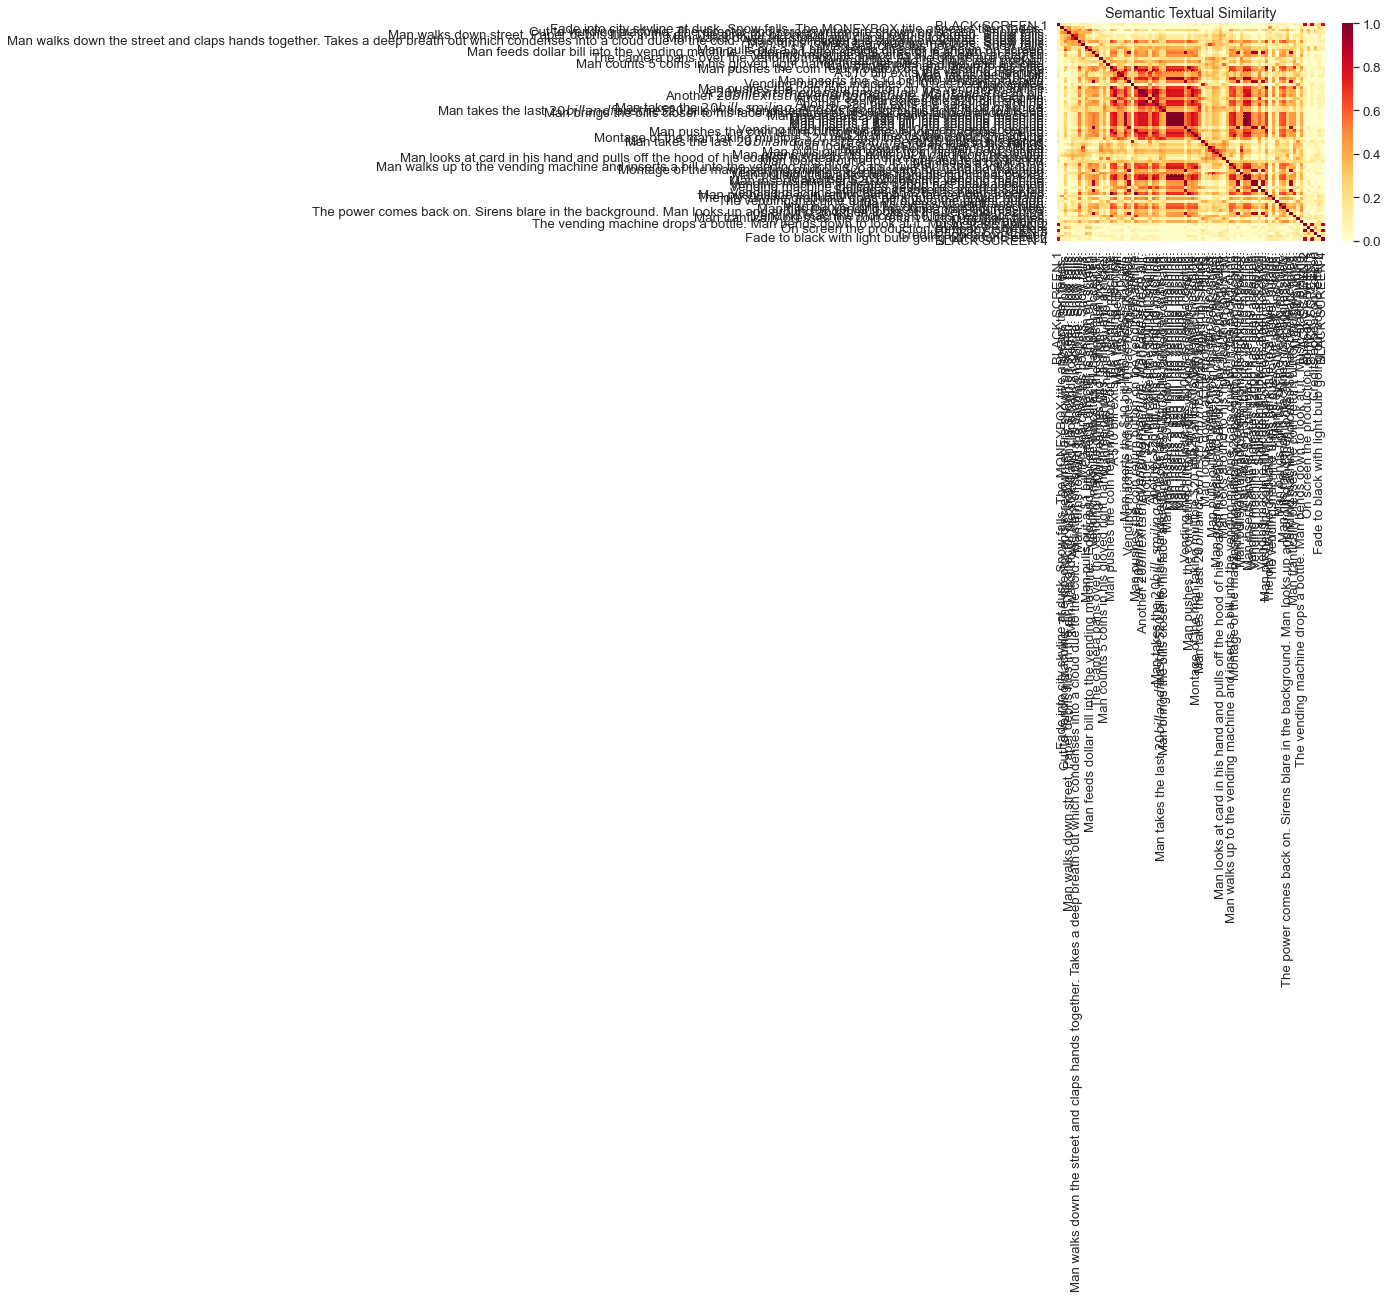

In [21]:
import pandas as pd

annotations = pd.read_csv("~/Projects/CDL/perceptual-dynamics/data/annotations/moneybox.csv")
transcript=annotations["Narrative details (external events)"]
messages = list(transcript)
embeddings=run_and_plot(messages)

# df=pd.DataFrame(messages)
# df.rolling(2, win_type='gaussian').sum(std=3)
# messages = list(df)
# embeddings=run_and_plot(messages)

In [ ]:
messages = list(transcript["Narrative details (external events)"][2:8])
embeddings=run_and_plot(messages)

In [ ]:
messages = list(transcript["Narrative details (external events)"][15:41])
embeddings=run_and_plot(messages)

In [ ]:
messages = list(transcript["Narrative details (external events)"][49:60])
embeddings=run_and_plot(messages)

In [ ]:
messages = list(transcript["Narrative details (external events)"][69:76])
embeddings=run_and_plot(messages)

In [ ]:
P1 = open("/Users/darrengu/Projects/CDL/perceptual-dynamics/code/Darren_Sherlock/raw/P1.txt", "r")
P2 = open("/Users/darrengu/Projects/CDL/perceptual-dynamics/code/Darren_Sherlock/raw/P2.txt", "r")

messages=[P1.read(), P2.read()]
embeddings=run_and_plot(messages)

In [ ]:
p1 = pd.read_csv("~/Projects/CDL/perceptual-dynamics/code/Darren_Sherlock/raw/P1_sentences.csv")
messages = list(p1["Narrative details (external events)"])
embeddings=run_and_plot(messages)


In [ ]:
p2 = pd.read_csv("~/Projects/CDL/perceptual-dynamics/code/Darren_Sherlock/raw/P2_sentences.csv")
messages = list(p2["Narrative details (external events)"])
embeddings=run_and_plot(messages)

In [ ]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)
               

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [ ]:
import pandas
import scipy
import math
import csv

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

### Evaluate Sentence Embeddings

In [ ]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
    sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
    """Returns the similarity scores"""
    return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))